In [6]:
import numpy as np
import io
import cv2
import random
from IPython.display import clear_output, Image, display
import PIL.Image

In [62]:
import gerber # https://pcb-tools.readthedocs.io/en/latest/documentation/rs274x.html#functions
stencil = gerber.read('solderpaste_top3.gbr') # read gerber file from eagle or Kicad
bound_x = stencil.bounds[0][1]
bound_y = stencil.bounds[1][1]
print("from gerber mm",bound_x,bound_y," CV Ver:",cv2.__version__)

from gerber mm 60.003 15.019  CV Ver: 4.5.1


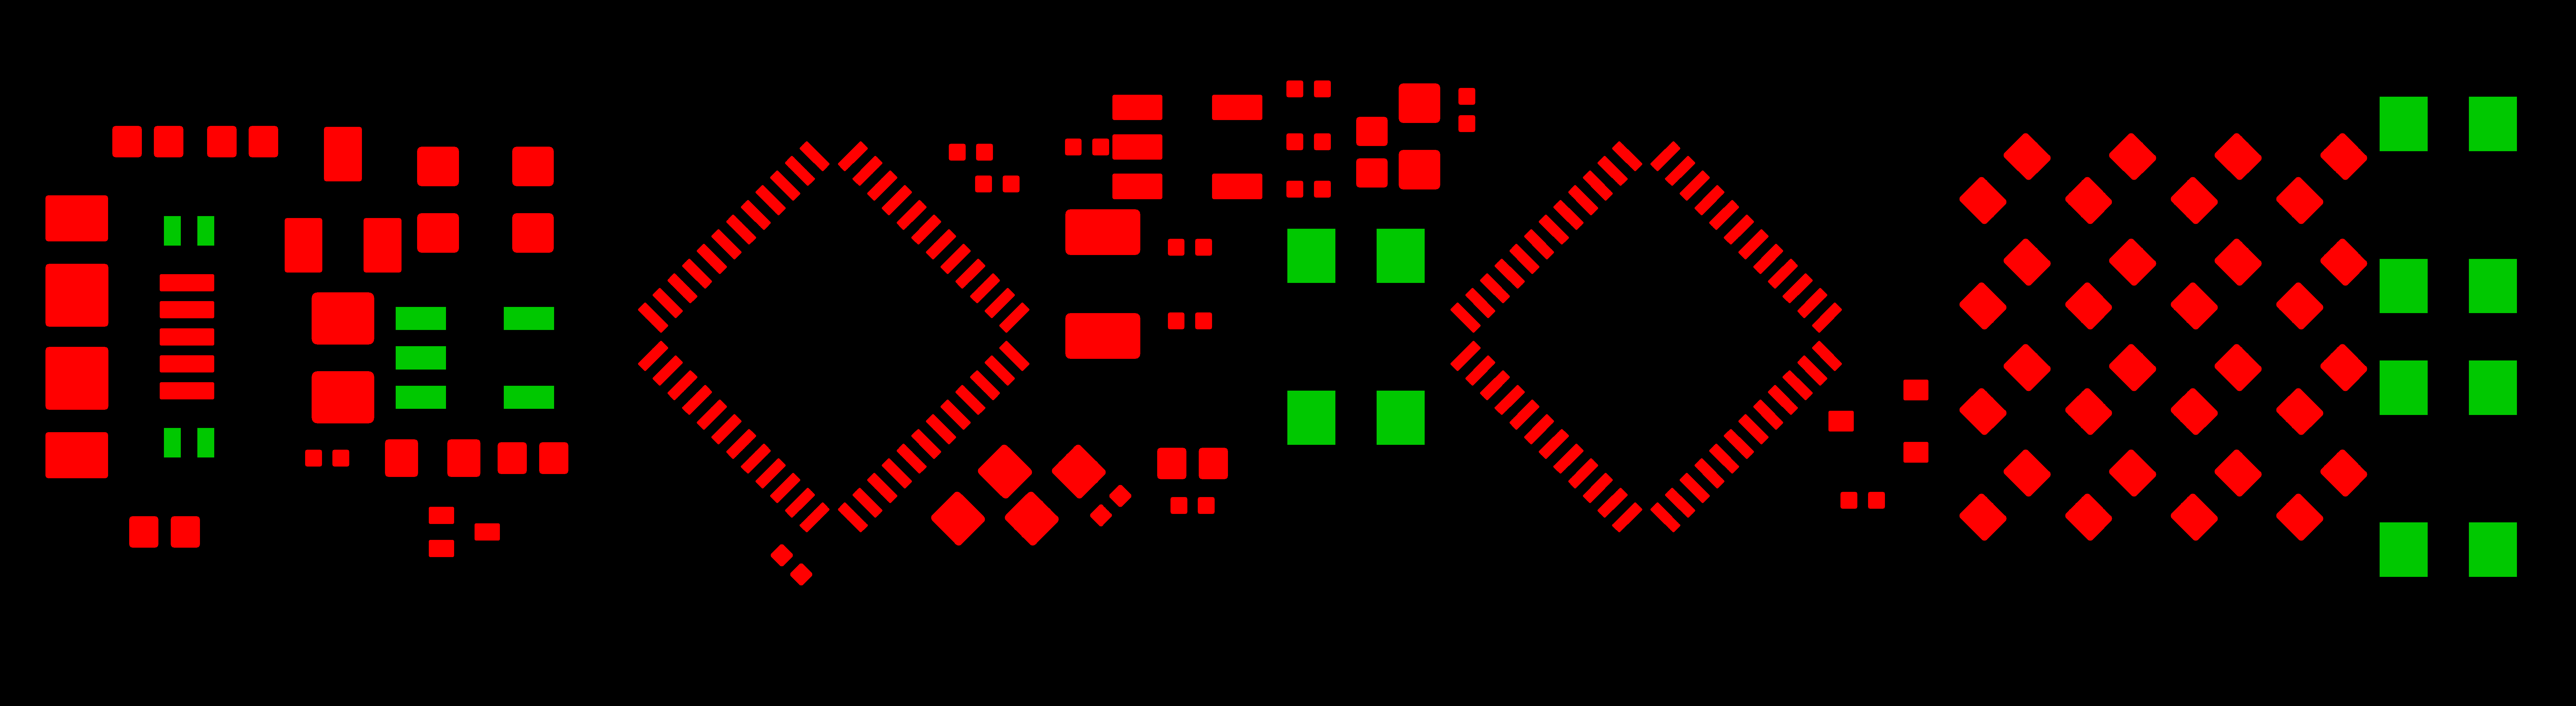

In [63]:
# Helper Function to Draw cv2 images in jupyter
def showarray(a, fmt='png'):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
# create a new Image using 128px per mm
height = int(bound_y) * 128 + 256
width  = int(bound_x) * 128 + 256
blank_image = np.zeros((height,width,3), np.uint8)
for i in stencil.primitives: # draw pads from gerber file
    if isinstance(i,gerber.primitives.Line ): # some elements are simple lines,need also thickness to correct fill 
        p1 = (int(i._start[0] * 128) , int(i._start[1] * 128))
        p2 = (int(i._end[0]   * 128) , int(i._end[1]   * 128) )
        cv2.line(   img=blank_image, pt1=p1,pt2=p2, 
                    color=(255,0,0) , thickness = int(i.aperture._diameter*128) , lineType = 8, shift = 0)
    elif isinstance(i,gerber.primitives.Rectangle ): # draw rectanges
        x1 = int((i._position[0] - i._width * 0.5)  * 128)
        y1 = int((i._position[1] - i._height* 0.5)  * 128)
        x2 = int((i._position[0] + i._width * 0.5)  * 128)
        y2 = int((i._position[1] + i._height* 0.5)  * 128)
        cv2.rectangle(blank_image, (x1,y1), (x2,y2), color=(0,200,0), thickness = -1)
flip_img = cv2.flip(blank_image, -1)
flip_img = cv2.flip(flip_img, 1)
showarray(flip_img)

drive len: 2564.6036928565045
New mm drive len: 335.29091780426586


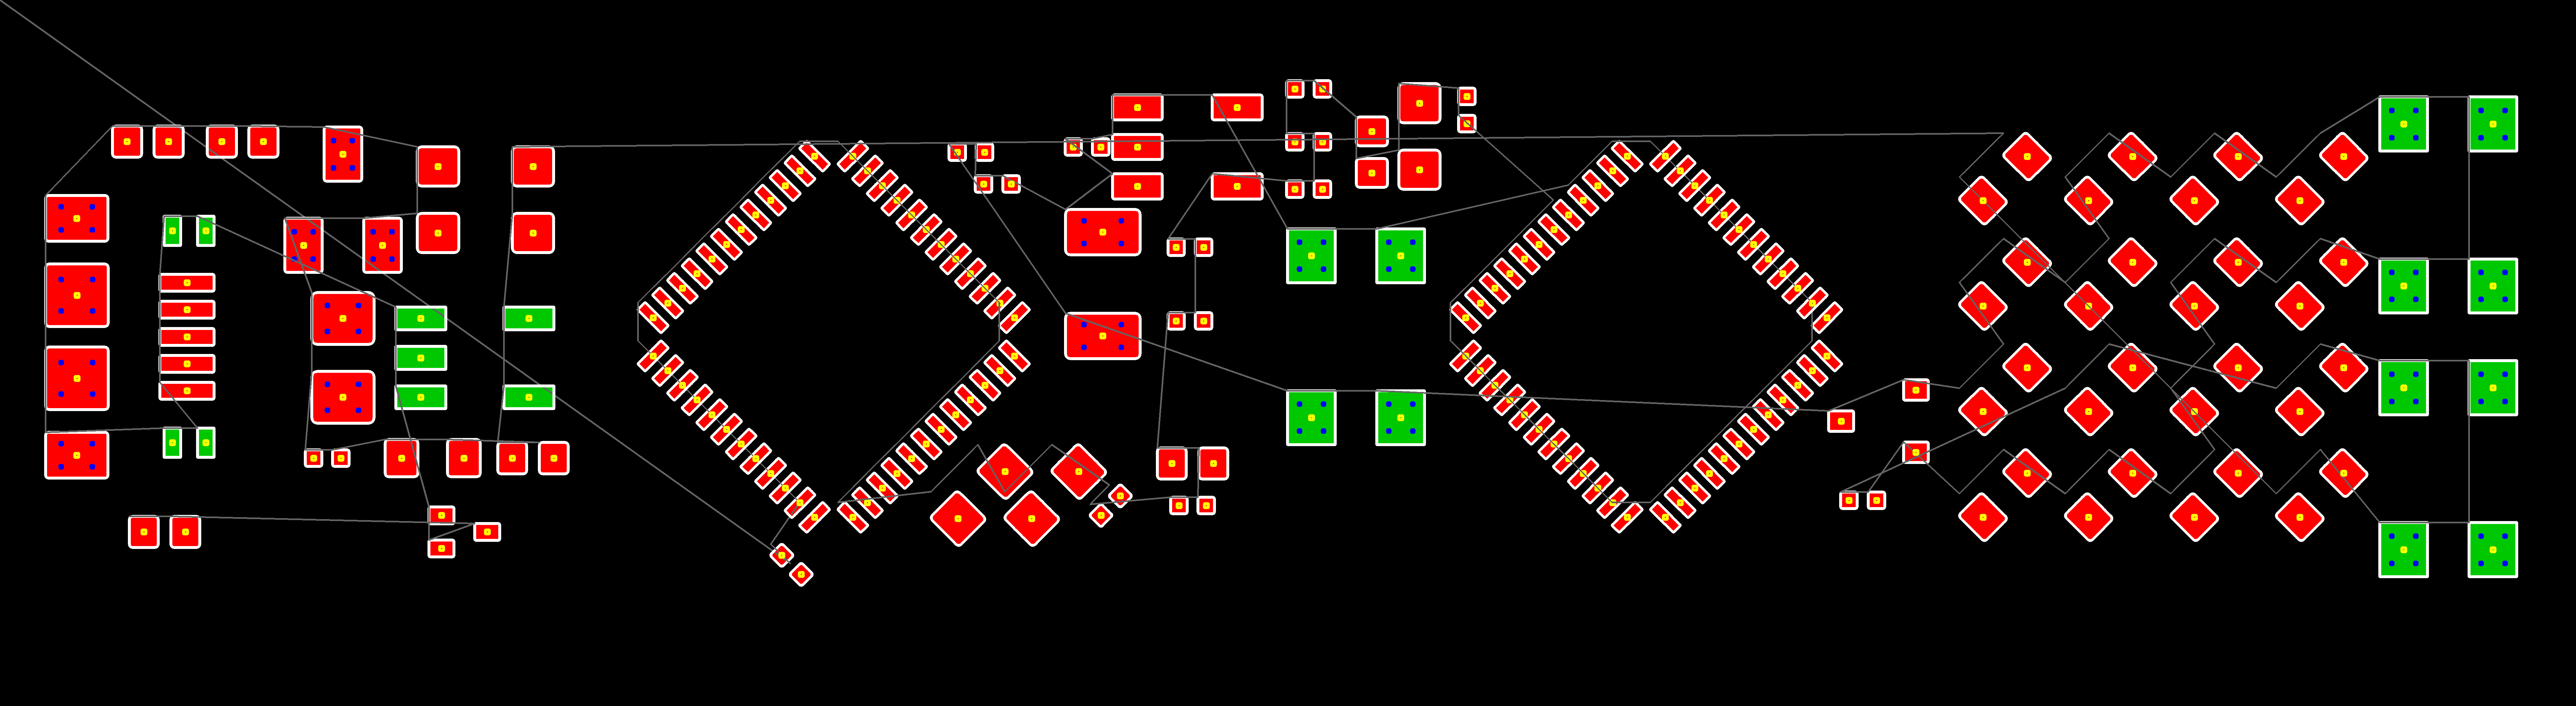

Pad Counter: 320


In [66]:
# found contours to find solder paste points
counter  = 0
imgOrg   = flip_img.copy()  
imgGray  = cv2.cvtColor(flip_img,cv2.COLOR_BGR2GRAY)
contours, hierarchy  = cv2.findContours(imgGray, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
csv=""
x_old=0
y_old=0 # for route 

'''
## START optimize route by simple TSP heuristic
def distance_contour(c1, c2): # compute distance 2 points 
    x1, y1, w1, h1 = cv2.boundingRect(c1)
    x2, y2, w2, h2 = cv2.boundingRect(c2)
    return ((x1 - x2)**2 + (y1 - y2)**2) ** 0.5
def tsp_len(seq): # compute distance full path
    l=0
    fr=seq[0]
    for i, contour in enumerate(seq):
        l=l+distance_contour(fr,contour)
        fr=contour
    return l
def swap_random(seq): # random swap elements
    idx = range(len(seq))
    i1, i2 = random.sample(idx, 2)
    seq[i1], seq[i2] = seq[i2], seq[i1]
def optimize_path(path, iterations=30000):
    l=tsp_len(path)
    for i in range(0, iterations): # <--- tune high values -> cpu load
        ccopy = path.copy()
        for ii in range(1, random.randint(1,7)): swap_random(ccopy) # random swaps
        lnew=tsp_len(ccopy)
        if lnew < l :
            l = lnew
            path = ccopy # apply when shorter path found
        if (i % 10000) == 0:  print("mm drive len:", l)
    print("New mm drive len:", l)
    return path
## END optimize route by simple TSP heuristic
'''
def distance_contour(c1, c2): # compute distance 2 points 
    x1, y1, w1, h1 = cv2.boundingRect(c1)
    x2, y2, w2, h2 = cv2.boundingRect(c2)
    return ((x1 - x2)**2 + (y1 - y2)**2) ** 0.5
def get_sort_list_by_start_point(points, fr):
   points.sort(key = lambda p: distance_contour(p,fr))
   return points
def optimize_path2(path):
    dest=[]
    dest.append(path[0])
    path.remove(path[0])
    while len(path) > 0:
        sort_list = get_sort_list_by_start_point(path,dest[-1])
        dest.append(path[0])
        path.remove(path[0])
    return dest

print("drive len:", tsp_len(contours) / 128.0)
contours = optimize_path2(contours)
print("New mm drive len:", tsp_len(contours) / 128.0)


for i, contour in enumerate(contours):
    #print(i);
    x, y, w, h = cv2.boundingRect(contour)
    if(x==0 & y==0): continue
    center1 = (x+w//2 -6, y+h//2 -6)
    center2 = (x+w//2 +6, y+h//2 +6)
    csv=csv + "\n" + str(x/128.0) + " ,  " + str(y/128.0)
    cv2.drawContours(imgOrg, contour, -1, (255, 255, 255), 8) # draw outline bounds

    cv2.line(   img=imgOrg, pt1=(x,y),pt2=(x_old,y_old), 
                    color=(100,100,100) , thickness = 4 , lineType = 8, shift = 0) # show trace, so looks like we need optimize driver too
    
    
    cv2.rectangle(imgOrg, center1, center2, (255, 255, 0), 8) # draw bounds
    counter=counter+1
    #if w > 160 or h > 160: # draw some extra dots on bigger pads, need 
    if cv2.contourArea(contour) > 18800: # or check by area size <---NEED to TUNE
        for xd in np.arange (x + w//4  , x + w , w//2):
            for yd in np.arange (y + h//4  , y + h , h//2):
                center1 = (xd - 4, yd - 4)
                center2 = (xd + 4, yd + 4)
                if cv2.pointPolygonTest(contour,(xd,yd),False)==1 :
                    cv2.rectangle(imgOrg, center1, center2, (0, 0, 255), 8) # draw bounds, TODO: add some patterns for bigger pads
                    csv=csv + "\n" + str(xd/128.0) + " ,  " + str(yd/128.0)
                    counter=counter+1
    
    x_old = x
    y_old = y
    
    
showarray(imgOrg)
print("Pad Counter:", counter)

In [67]:
print(csv)


19.015625 ,  13.5625
18.546875 ,  13.1015625
19.2421875 ,  12.09375
18.890625 ,  11.7421875
18.53125 ,  11.3828125
18.1796875 ,  11.03125
17.828125 ,  10.6796875
17.4765625 ,  10.328125
17.1171875 ,  9.96875
16.765625 ,  9.6171875
16.4140625 ,  9.265625
16.0625 ,  8.9140625
15.703125 ,  8.5546875
15.3515625 ,  8.203125
15.3515625 ,  7.28125
15.703125 ,  6.9296875
16.0625 ,  6.578125
16.4140625 ,  6.2265625
16.765625 ,  5.8671875
17.1171875 ,  5.515625
17.4765625 ,  5.1640625
17.828125 ,  4.8125
18.1796875 ,  4.453125
18.53125 ,  4.1015625
18.890625 ,  3.75
19.2421875 ,  3.3984375
20.1640625 ,  3.3984375
20.515625 ,  3.75
20.8671875 ,  4.1015625
21.21875 ,  4.453125
21.578125 ,  4.8125
21.9296875 ,  5.1640625
22.28125 ,  5.515625
22.6328125 ,  5.8671875
22.9921875 ,  6.2265625
23.34375 ,  6.578125
23.6953125 ,  6.9296875
24.046875 ,  7.28125
24.046875 ,  8.203125
23.6953125 ,  8.5546875
23.34375 ,  8.9140625
22.9921875 ,  9.265625
22.6328125 ,  9.6171875
22.28125 ,  9.96875
21.9296875 